In [15]:
import pandas as pd
import pandapower as pp
from pandapower import plotting
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math
import numba

In [16]:
#for 13:20 pm on June 27 2020
# Create empty net
# https://pandapower.readthedocs.io/en/v2.4.0/elements/empty_network.html
net = pp.create_empty_network()

#lines = gpd.read_file('hv_lines.geojson')

#hv_lines = lines['geometry']


#initialize line voltages in MW assuming ibiza/formentera represented as a load bus

hv220=220
hv132=132
#power factor = 0.9, Q = P*tan(arccos(0.9))
#tan(arccos(0.9))=0.484322
PF= 0.484322


#residential loads in MW for each load bus,weighted avg of population


#initialize bus location variables for geodata epsg.4326
#mallorca
loc_eb=(3.1583316, 39.5822638)
loc_ll=(3.0399121, 39.6736644)
loc_sr=(2.6788739, 39.6511746)
loc_va=(2.5492521, 39.5843260)
loc_so=(2.7442129,39.6002680)
loc_mp=(3.092442,39.809435) #murterar
loc_gs=(3.42746869,39.73867947) #cala mesquida
loc_sp=(2.50895716,39.53767893)
loc_cas = (2.701667000000000,39.547221999999998) #san joan deu
#menorca
loc_cb = (3.83379024,39.93198792)
loc_ciut=(3.8553116,40.0033945)
loc_merc = (4.09591994,39.97708936)
loc_drag = (4.2366714,39.8912109)
loc_mahon = (4.25796449,39.89715096)
#ibiza
loc_ibiza=(1.4310005,38.9192119)



#loc_cas = (2.7243168,39.5683692)
#loc_cas = (2.689444,39.56750)


#Initialize line lengths from qgis, only 220 and 132 lines in KM. 

IB_SP=126 #https://www.ree.es/sites/default/files/01_ACTIVIDADES/Documentos/Romulo2_en.pdf

#mallorca line lengths
SP_Val=6
Val_SR1=15
Val_SR2=15
SR_SO=9
CA_SO = 7
SR_LL=34
SO_LL=29
LL_MTR1=17
LL_MTR2=16
LL_EB1=15
LL_EB2=15
EB_GESA=30

#menorca line lengths
GESA_CB=41
CB_CIUT = 8
drag_mahon = 5
merc_drag = 15
ciut_drag = 36
ciut_merc = 21



In [17]:
#create buses on mallorca

b_eb_lv = pp.create_bus(net, vn_kv=hv132, name = "Es Bessons LV", geodata=loc_eb)
b_eb_hv = pp.create_bus(net, vn_kv=hv220, name = "Es Bessons HV", geodata=loc_eb)

b_ll = pp.create_bus(net, vn_kv=hv220, name = "LLubi", geodata=loc_ll)
b_sr = pp.create_bus(net, vn_kv=hv220, name = "Son Rues", geodata=loc_sr)
b_va = pp.create_bus(net, vn_kv=hv220, name = "Valldurgent", geodata=loc_va)
b_so = pp.create_bus(net, vn_kv=hv220, name = "Son Orlandis", geodata=loc_so)
b_mp = pp.create_bus(net, vn_kv=hv220, name = "Murterar Power", geodata=loc_mp)
b_gs = pp.create_bus(net, vn_kv=hv132, name = "Cala mesquida", geodata=loc_gs)

b_cas = pp.create_bus(net, vn_kv=hv220, name = "Cas Tresoare", geodata=loc_cas)

#create buses for menorca (both modelled as load buses on 132kV network)
b_cb = pp.create_bus(net, vn_kv=hv132, name = "Cala en Bosc", geodata=loc_cb)
b_ciut = pp.create_bus(net, vn_kv=hv132, name = "Ciutadella", geodata=loc_ciut)
b_mahon = pp.create_bus(net, vn_kv=hv132, name = "Mahon", geodata=loc_mahon)
b_drag = pp.create_bus(net, vn_kv=hv132, name = "Dragonera SS", geodata=loc_drag)
b_merc = pp.create_bus(net, vn_kv=hv132, name = "Es Merceds SS", geodata=loc_merc)

#create bus representing ibiza/formentera (load bus on 132kV network)
b_ibiza = pp.create_bus(net, vn_kv=hv132, name = "Elvissa PS", geodata=loc_ibiza)

#create buses for mainland interconnector and trafo

b_sp_lv = pp.create_bus(net, vn_kv=hv132, name = "SP HVDC LV", geodata=loc_sp) 
b_sp_hv = pp.create_bus(net, vn_kv=hv220, name = "SP HVDC HV", geodata=loc_sp)

net.bus

,name,vn_kv,type,zone,in_service
0,Es Bessons LV,132.0,b,None,True
1,Es Bessons HV,220.0,b,None,True
2,LLubi,220.0,b,None,True
3,Son Rues,220.0,b,None,True
4,Valldurgent,220.0,b,None,True
5,Son Orlandis,220.0,b,None,True
6,Murterar Power,220.0,b,None,True
7,Cala mesquida,132.0,b,None,True
8,Cas Tresoare,220.0,b,None,True
9,Cala en Bosc,132.0,b,None,True


In [18]:
#create load buses
#residential loads in MW for each load bus,weighted avg of population

#Mallorca load at 13:20 is 483.86 MW
p_eb=36.63 #es bessons
p_ll=22.67 #llubi
p_sr=102.89 #son reus
p_va=60.44 #valldurgent
p_so=96.92 #son orlandis
p_mp=53.31 #murterar
p_gs=21.44  #cala mesquida
p_sp= 33.39 #santa ponsa
p_cas=56.17 #cas tresora

#menorca load at 13:20 is 50.43 MW
p_ciut=16.11 
p_cb = 10.95
p_mahon= 23.37

#ibiza and formentera combined load minus generation at 13:20. 
p_ibiza=79.09

L_eb = pp.create_load(net, bus=b_eb_lv, p_mw=p_eb, q_mvar=p_eb*PF, name = "Load Es Bessons")
L_ll = pp.create_load(net, bus=b_ll, p_mw=p_ll, q_mvar=p_ll*PF, name = "Load LLubi")
L_sr = pp.create_load(net, bus=b_sr, p_mw=p_sr, q_mvar=p_sr*PF, name = "Load Son Reus")
L_va = pp.create_load(net, bus=b_va, p_mw=p_va, q_mvar=p_va*PF, name = "Load Valldurgent")
L_so = pp.create_load(net, bus=b_so, p_mw=p_so, q_mvar=p_so*PF, name = "Load Son Orlandis")
L_mp = pp.create_load(net, bus=b_mp, p_mw=p_mp, q_mvar=p_mp*PF, name = "Load Murtretar") 
L_gs = pp.create_load(net, bus=b_gs, p_mw=p_gs, q_mvar=p_gs*PF, name = "Load GESA")
L_sp = pp.create_load(net, bus=b_sp_lv, p_mw=p_sp, q_mvar=p_sp*PF, name = "Load Santa Ponsa")
l_cas =pp.create_load(net, bus=b_cas, p_mw=p_cas, q_mvar=p_cas*PF, name = "Load Cas Tresorer")

L_cb = pp.create_load(net, bus=b_cb, p_mw=p_cb, q_mvar=p_cb*PF, name = "Load Cala en bosc")
L_ciut = pp.create_load(net, bus=b_ciut, p_mw=p_ciut, q_mvar=p_ciut*PF, name = "Load ciutadella")
L_mahon = pp.create_load(net, bus=b_drag, p_mw=p_mahon, q_mvar=p_mahon*PF, name = "Load mahon")

L_ibiza = pp.create_load(net, bus=b_ibiza, p_mw=p_ibiza, q_mvar=p_ibiza*PF, name = "Load Ibiza/Formentera")

L_sp = pp.create_load(net, bus=b_sp_lv, p_mw=0, q_mvar=237, name = "Reactor")


net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load Es Bessons,0,36.63,17.740715,0.0,0.0,NaN,1.0,True,wye
1,Load LLubi,2,22.67,10.979580,0.0,0.0,NaN,1.0,True,wye
2,Load Son Reus,3,102.89,49.831891,0.0,0.0,NaN,1.0,True,wye
3,Load Valldurgent,4,60.44,29.272422,0.0,0.0,NaN,1.0,True,wye
4,Load Son Orlandis,5,96.92,46.940488,0.0,0.0,NaN,1.0,True,wye
5,Load Murtretar,6,53.31,25.819206,0.0,0.0,NaN,1.0,True,wye
6,Load GESA,7,21.44,10.383864,0.0,0.0,NaN,1.0,True,wye
7,Load Santa Ponsa,15,33.39,16.171512,0.0,0.0,NaN,1.0,True,wye
8,Load Cas Tresorer,8,56.17,27.204367,0.0,0.0,NaN,1.0,True,wye
9,Load Cala en bosc,9,10.95,5.303326,0.0,0.0,NaN,1.0,True,wye


In [19]:
#define generation at 120pm on mallorca

P_ccgt = 316
P_trash = 29
P_cogen = 3.2
P_solar = 39 
P_PV_Vall= 80

#define Menorca generation 33MW DIESEL 21.7MW GT (.1 wind, 1.1 solar, all into grid at mahon)
P_MDG = 55.9
P_PV_Mahon = 100



#create generator buses
#pandapower.create_sgen(net, bus, p_mw, q_mvar=0, sn_mva=nan, name=None)

#gen_cas = pp.create_sgen(net, bus = b_cas, p_mw = P_ccgt/2+P_cogen , q_mvar=  (P_ccgt/2+P_cogen)*PF , name = "Cas Tresoer Gas Turbine")
#gen_sr = pp.create_sgen(net, bus = b_sr, p_mw = P_ccgt/2+P_trash, q_mvar=(P_ccgt/2+P_trash)*PF , name = "Son Reus GT and Waste")

gen_sr = pp.create_sgen(net, bus = b_sr, p_mw = P_ccgt+P_trash+P_cogen, q_mvar=(P_ccgt+P_trash+P_cogen)*PF , name = "Son Reus GT and Waste")
gen_solar = pp.create_sgen(net, bus = b_ll, p_mw = P_solar, q_mvar=0, name = "LLubi PV")
gen_mahon = pp.create_sgen(net, bus = b_mahon, p_mw = (P_MDG +P_PV_Mahon), q_mvar = (P_MDG + P_PV_Mahon)*PF, name = 'Mahon Diesel Gen')
gen_solar_ES = pp.create_sgen(net, bus = b_va, p_mw = P_PV_Vall, q_mvar=0, name = "Valldurgente PV")

#gen_cas = pp.create_gen(net, bus = b_cas, p_mw = P_ccgt/2+P_cogen, vm_pu = 1.00, name = "Cas Tresoer Gas Turbine")
#gen_sr = pp.create_gen(net, bus = b_sr, p_mw = P_ccgt/2+P_trash, vm_pu = 1.00, name = "Son Reus GT and Waste")
#gen_solar = pp.create_gen(net, bus = b_ll, p_mw = P_solar, vm_pu = 1.00, name = "LLubi PV")
#gen_mahon = pp.create_gen(net, bus = b_mahon, p_mw = P_MDG, vm_pu = 1.00, name = 'Mahon Diesel Gen')

#create swing bus to represent HVDC cable

swing_hvdc = pp.create_ext_grid(net, bus=b_sp_hv, vm_pu=1.00, name="Cometa Swing Bus")

net.sgen.tail()

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,Son Reus GT and Waste,3,348.2,168.64092,NaN,1.0,True,wye,True
1,LLubi PV,2,39.0,0.00000,NaN,1.0,True,wye,True
2,Mahon Diesel Gen,11,155.9,75.50580,NaN,1.0,True,wye,True
3,Valldurgente PV,4,80.0,0.00000,NaN,1.0,True,wye,True


In [20]:
#create 220 to 132kV transformers at es bessons and santa ponsa, typical capacity zotero
trans_sp = pp.create_transformer_from_parameters(net, hv_bus=b_sp_hv, lv_bus=b_sp_lv, sn_mva=400, vn_hv_kv=220,\
                                                  vn_lv_kv=132, vkr_percent=1, vk_percent=10, pfe_kw=400.*0.01, i0_percent=1)

trans_eb = pp.create_transformer_from_parameters(net, hv_bus=b_eb_hv, lv_bus=b_eb_lv, sn_mva=400, vn_hv_kv=220,\
                                                 vn_lv_kv=132, vkr_percent=1, vk_percent=10, pfe_kw=400*0.01, i0_percent=1)

net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,None,None,16,15,400.0,220.0,132.0,10.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
1,None,None,1,0,400.0,220.0,132.0,10.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True


In [21]:
#create lines and attach them to the nodes....
#create_line(net, “line1”, from_bus = 0, to_bus = 1, length_km=0.1, std_type=”NAYY 4x50 SE”)

#220 overhead typical properties....gull aw
Rkm_220OH = 0.13
Xkm_220OH = 0.425
Cnfkm_220OH = 8.2
MaxIkA220 = 0.8

#132 overhead properties....hawk aw
Rkm_132OH = 0.14
Xkm_132OH = 0.42
Cnfkm_132OH = 8.2
MaxIkA132 = 0.66

#132 Underwater/ground properties IBIZA MALLORCA
Rkm_132UW = 0.14
Xkm_132UW = 0.10
Cnfkm_132UW = 200
MaxIkA132UW = 1.6

#132 Underwater/ground properties Mallorca Menorca
Rkm_132UWmen = 0.14
Xkm_132UWmen = 0.10
Cnfkm_132UWmen = 200
MaxIkA132men = 1.6


#pandapower.create_line_from_parameters(net, from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka, name=None, index=None, type=None, geodata=None, in_service=True, df=1.0, parallel=1, g_us_per_km=0.0, max_loading_percent=nan, alpha=None, temperature_degree_celsius=None, r0_ohm_per_km=nan, x0_ohm_per_km=nan, c0_nf_per_km=nan, g0_us_per_km=0, endtemp_degree=None, **kwargs)
#this needs to be updated to reflect underwater 132kV properties #CHANGE STD TYPE p = 2*100MW


line_ibiza_sp1 = pp.create_line_from_parameters(net, from_bus = b_sp_lv, to_bus = b_ibiza , length_km= IB_SP , r_ohm_per_km=Rkm_132UW, x_ohm_per_km=Xkm_132UW,
                                                c_nf_per_km = Cnfkm_132UW, max_i_ka =MaxIkA132UW, name = 'Ibiza_SP1', geodata = [loc_ibiza, loc_sp])
line_ibiza_sp2 = pp.create_line_from_parameters(net, from_bus = b_sp_lv, to_bus = b_ibiza, length_km= IB_SP ,  r_ohm_per_km=Rkm_132UW, x_ohm_per_km=Xkm_132UW,
                                                c_nf_per_km = Cnfkm_132UW, max_i_ka =MaxIkA132UW , name = 'Ibiza_SP2', geodata = [loc_ibiza, loc_sp])


#220kV network on mallorca
line_sp_val1 = pp.create_line_from_parameters(net,  from_bus = b_sp_hv, to_bus = b_va , length_km= SP_Val , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'SP_Val', geodata = [loc_sp, loc_va])
line_sp_val2 = pp.create_line_from_parameters(net,  from_bus = b_sp_hv, to_bus = b_va , length_km= SP_Val , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'SP_Val', geodata = [loc_sp, loc_va])

#two lines from santa ponsa to Valldurgent (overpass.eu)
line_val_sr1 = pp.create_line_from_parameters(net,  from_bus = b_va, to_bus = b_sr , length_km= Val_SR1 , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH,\
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name ='val_sr1', geodata = [loc_va, loc_sr])
line_val_sr2 = pp.create_line_from_parameters(net,  from_bus = b_va, to_bus = b_sr , length_km= Val_SR2 , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH,\
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'val_sr2', geodata = [loc_va, loc_sr])

line_sr_so = pp.create_line_from_parameters(net,  from_bus = b_sr, to_bus = b_so , length_km= SR_SO , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                            c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'sr_so', geodata = [loc_sr, loc_so])
line_cas_so1 = pp.create_line_from_parameters(net, from_bus = b_cas, to_bus = b_so, length_km= CA_SO, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'cas_so1', geodata = [loc_cas, loc_so])
line_cas_so2 = pp.create_line_from_parameters(net, from_bus = b_cas, to_bus = b_so, length_km= CA_SO, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                              c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name ='cas_so2', geodata = [loc_cas, loc_so])

line_sr_ll = pp.create_line_from_parameters(net,  from_bus = b_sr, to_bus = b_ll , length_km= SR_LL , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                            c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'sr_ll', geodata = [loc_sr, loc_ll])
line_so_ll = pp.create_line_from_parameters(net,  from_bus = b_so, to_bus = b_ll , length_km= SO_LL , r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                            c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'so_ll', geodata = [loc_so, loc_ll])


line_LL_MP1 = pp.create_line_from_parameters(net, from_bus = b_ll, to_bus = b_mp, length_km= LL_MTR1, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                             c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name ='ll_mp1', geodata = [loc_ll, loc_mp])
line_LL_MP2 = pp.create_line_from_parameters(net, from_bus = b_ll, to_bus = b_mp, length_km= LL_MTR2, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                             c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name = 'll_mp2', geodata = [loc_ll, loc_mp])

line_LL_EB1 = pp.create_line_from_parameters(net, from_bus = b_ll, to_bus = b_eb_hv, length_km= LL_EB1, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                             c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name ='ll_eb1', geodata = [loc_ll, loc_eb])
line_LL_EB2 = pp.create_line_from_parameters(net, from_bus = b_ll, to_bus = b_eb_hv, length_km= LL_EB2, r_ohm_per_km=Rkm_220OH, x_ohm_per_km=Xkm_220OH, \
                                             c_nf_per_km = Cnfkm_220OH, max_i_ka =MaxIkA220, name ='ll_eb2', geodata = [loc_ll, loc_eb])


#132 lines on mallorca
line_EB_GESA = pp.create_line_from_parameters(net, from_bus = b_eb_lv, to_bus = b_gs, length_km= EB_GESA,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH, \
                                              c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name = 'eb_gesa', geodata = [loc_eb, loc_gs]) #change std type


#this needs to be updated to reflect underwater 132kV properties
line_GESA_cb = pp.create_line_from_parameters(net, from_bus = b_gs, to_bus = b_cb, length_km= GESA_CB,  r_ohm_per_km=Rkm_132UWmen, x_ohm_per_km=Xkm_132UWmen, \
                                              c_nf_per_km = Cnfkm_132UWmen, max_i_ka =MaxIkA132men, name ='gesa_cb', geodata = [loc_gs, loc_cb]) #change std type

#standard 132 overhead lines
line_cb_Ciut = pp.create_line_from_parameters(net, from_bus = b_cb, to_bus = b_ciut, length_km= CB_CIUT,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH, \
                                              c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='cb_cuit', geodata = [loc_cb, loc_ciut])
line_ciut_drag = pp.create_line_from_parameters(net, from_bus = b_ciut, to_bus = b_drag, length_km= ciut_drag,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH,\
                                                c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='ciut_drag', geodata = [loc_ciut, loc_drag])
line_ciut_merc = pp.create_line_from_parameters(net, from_bus = b_ciut, to_bus = b_merc, length_km= ciut_merc,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH, \
                                                c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='ciut_merc',  geodata = [loc_ciut, loc_merc])
line_merc_drag =  pp.create_line_from_parameters(net, from_bus = b_merc, to_bus = b_drag, length_km= merc_drag,   r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH, \
                                                 c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='merc_drag', geodata = [loc_merc, loc_drag] )
line_drag_mahon1 = pp.create_line_from_parameters(net, from_bus = b_drag, to_bus = b_mahon, length_km= drag_mahon,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH,\
                                                  c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='drag_mahon1', geodata = [loc_drag, loc_mahon])
line_drag_mahon2 = pp.create_line_from_parameters(net, from_bus = b_drag, to_bus = b_mahon, length_km= drag_mahon,  r_ohm_per_km=Rkm_132OH, x_ohm_per_km=Xkm_132OH, \
                                                  c_nf_per_km = Cnfkm_132OH, max_i_ka =MaxIkA132, name ='drag_mahon2' , geodata = [loc_drag, loc_mahon])

net.line



,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Ibiza_SP1,None,15,14,126.0,0.14,0.100,200.0,0.0,1.60,1.0,1,None,True
1,Ibiza_SP2,None,15,14,126.0,0.14,0.100,200.0,0.0,1.60,1.0,1,None,True
2,SP_Val,None,16,4,6.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
3,SP_Val,None,16,4,6.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
4,val_sr1,None,4,3,15.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
5,val_sr2,None,4,3,15.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
6,sr_so,None,3,5,9.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
7,cas_so1,None,8,5,7.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
8,cas_so2,None,8,5,7.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True
9,sr_ll,None,3,2,34.0,0.13,0.425,8.2,0.0,0.80,1.0,1,None,True


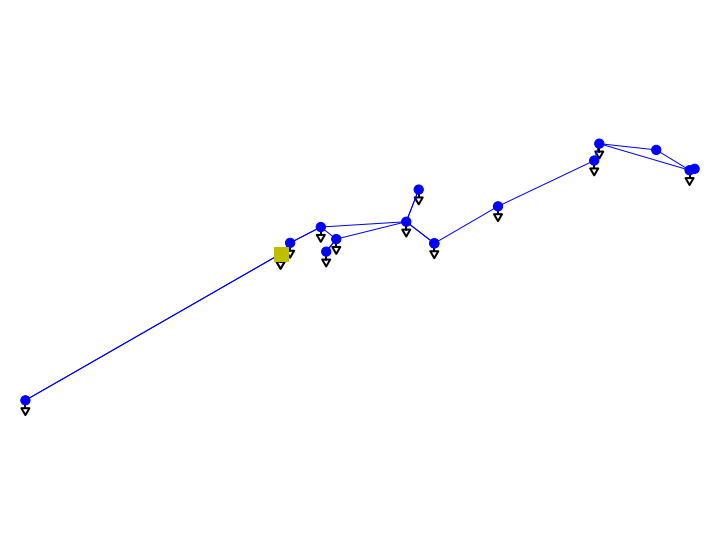

In [22]:
pp.runpp(net)



pp.to_excel(net, 'ppnet1320.xlsx')
pp.plotting.simple_plot(net, respect_switches=False, line_width=1.0, bus_size=1.0, ext_grid_size=1.0, trafo_size=1.0, \
                        plot_loads=True, plot_sgens=False, load_size=1.0, sgen_size=3.0, switch_size=1.0, switch_distance=1.0, plot_line_switches=False, scale_size=True, bus_color='b', line_color='blue', trafo_color='k', ext_grid_color='y', switch_color='k', library='igraph', show_plot=True, ax=None)



#pp.plotting.create_bus_collection(net, buses=None, size=5, patch_type='circle', color=None, z=None, \
                                          #cmap=None, norm=None, infofunc=None, picker=False, bus_geodata=None, cbar_title='Bus Voltage [pu]')

#pp.plotting.create_line_collection(net, lines=None, line_geodata=None, bus_geodata=None, use_bus_geodata=True, infofunc=None, \
                                          # cmap=None, norm=None, picker=False, z=None, cbar_title='Line Loading [%]', clim=None, plot_colormap=True)

#pp.plotting.create_trafo_collection(net, trafos=None, picker=False, size=None, infofunc=None, cmap=None, norm=None, z=None, \
                                            #clim=None, cbar_title='Transformer Loading', plot_colormap=True, bus_geodata=None)

#pp.plotting.draw_collections(collections, figsize=10, ax=None, plot_colorbars=True, set_aspect=True, axes_visible=False, copy_collections=True, draw=True)


net.res_line


pp.to_json(net, "BI1320test.json")
#print(net.bus_geodata)
#print(net.res_bus)
#print(net.res_line)
#print(net.line)
#pd_bus = pd.DataFrame(net.res_bus)
#pd_line = pd.DataFrame(net.res_line)

#pq_load= ((net.load.p_mw)**2 + (net.load.q_mvar)**2)**0.5
#pq_load_sum=pq_load.sum()

#print(pq_load_sum)

#gdf_busloc = gpd.GeoDataFrame(net.bus_geodata, geometry=gpd.points_from_xy(net.bus_geodata.x, net.bus_geodata.y))










In [23]:
pp.runpp(net)
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,43.526432,-111.518951,-39.545000,-19.152513,3.981432,-130.671465,0.529729,0.196269,0.529729,0.988440,-1.690825,0.979182,-6.203788,33.108070
1,43.526432,-111.518951,-39.545000,-19.152513,3.981432,-130.671465,0.529729,0.196269,0.529729,0.988440,-1.690825,0.979182,-6.203788,33.108070
2,-55.321017,-29.782887,55.384276,29.239763,0.063259,-0.543124,0.164882,0.163958,0.164882,1.000000,0.000000,1.002444,0.139501,20.610295
3,-55.321017,-29.782887,55.384276,29.239763,0.063259,-0.543124,0.164882,0.163958,0.164882,1.000000,0.000000,1.002444,0.139501,20.610295
4,-45.604276,-43.875974,45.761572,42.496723,0.157296,-1.379251,0.165672,0.162280,0.165672,1.002444,0.139501,1.009927,0.381549,20.709032
5,-45.604276,-43.875974,45.761572,42.496723,0.157296,-1.379251,0.165672,0.162280,0.165672,1.002444,0.139501,1.009927,0.381549,20.709032
6,134.445565,45.704735,-133.966405,-45.275118,0.479160,0.429617,0.368995,0.369947,0.369947,1.009927,0.381549,1.003132,-0.156098,46.243335
7,-28.085000,-13.602183,28.103024,12.784015,0.018024,-0.818169,0.081746,0.080771,0.081746,1.001796,-0.240410,1.003132,-0.156098,10.218312
8,-28.085000,-13.602183,28.103024,12.784015,0.018024,-0.818169,0.081746,0.080771,0.081746,1.001796,-0.240410,1.003132,-0.156098,10.218312
9,19.341291,-11.889151,-19.299325,7.697602,0.041966,-4.191549,0.058995,0.053930,0.058995,1.009927,0.381549,1.011076,0.007693,7.374363


In [24]:
pd_bus = pd.DataFrame(net.res_bus)
pd_line = pd.DataFrame(net.line_geodata)


gdf_busloc = gpd.GeoDataFrame(net.bus_geodata, geometry=gpd.points_from_xy(net.bus_geodata.x, net.bus_geodata.y))

#print(gdf_busloc)

l1 = [*range(0, 23, 1)]
l2 = [*range(0, 23, 1)]


for i in range(0,23) :
    l1[i] = LineString(pd_line['coords'][i])
    l2[i] = i
                    
d = {'col1': l2, 'geometry': l1}



df=pd.DataFrame(d)

pd_lineinfo = pd.DataFrame(net.res_line)



pd_lineinfo['geometry'] = df['geometry']


gdf_lineloc = gpd.GeoDataFrame(pd_lineinfo, crs="EPSG:4326")

In [42]:
gdf_lineloc.to_file("lineBI_loc.shp")